In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from learning_wavelets.data.datasets import im_dataset_bsd68
from learning_wavelets.image_utils import trim_padding
from learning_wavelets.keras_utils.load_model import unpack_model
from learning_wavelets.models.learnlet_model import Learnlet
from learning_wavelets.models.unet import unet

In [3]:
plt.rcParams['figure.figsize'] = (480/8, 320/8)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
tf.random.set_seed(0)

In [5]:
def build_learnlet_subclassing(**run_params):
    model = Learnlet(**run_params)
    model.build([[None, None, None, 1], [None, 1]])
    return model

In [6]:
all_net_params = [
    {
        'name': 'unet_0_55',
        'init_function': unet,
        'run_params': {
            'n_layers': 5, 
            'pool': 'max', 
            "layers_n_channels": [64, 128, 256, 512, 1024], 
            'layers_n_non_lins': 2,
            'non_relu_contract': False,
            'bn': True,
            'input_size': (None, None, 1),
        },
        'run_id': 'unet_dynamic_st_bsd500_0_55_1576668365',
        'epoch': 500,
    },
]

dynamic_denoising_net_params = [
{
        'name': 'learnlet',
        'init_function': build_learnlet_subclassing,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 64, 
                'mixing_details': False,    
                'skip_connection': True,
                'kernel_size': 11,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'threshold_kwargs':{
                'noise_std_norm': True,
            },
            'n_scales': 5,
            'exact_reconstruction': True,
            'n_reweights_learn': 1,
            'undecimated': True,
            'clip': False,
        },
        'run_id': 'learnlet_subclassed_undecimated_exact_reco_64_dynamic_soft_thresholding_bsd500_0.0_55.0_None_1582907244',
        'epoch': 100,
    },
]

In [7]:
noise_std = 30

In [8]:
im_ds = im_dataset_bsd68(
    mode='testing', 
    batch_size=1, 
    patch_size=None, 
    noise_std=noise_std, 
    return_noise_level=True,
    n_pooling=5,
    n_samples=1,
)

In [9]:
(im_noisy, tf_noise_std), im_gt, orig_im_shape = next(iter(im_ds))

In [10]:
unet_model = unpack_model(**all_net_params[0])
im_denoised_unet = unet_model(im_noisy)
learnlet_model = unpack_model(**dynamic_denoising_net_params[0])
im_denoised_learnlet = learnlet_model([im_noisy, tf_noise_std])

In [11]:
images_to_plot = {
    'original': im_gt,
    'noisy': im_noisy,
    'unet': im_denoised_unet,
    'learnlets': im_denoised_learnlet,
}

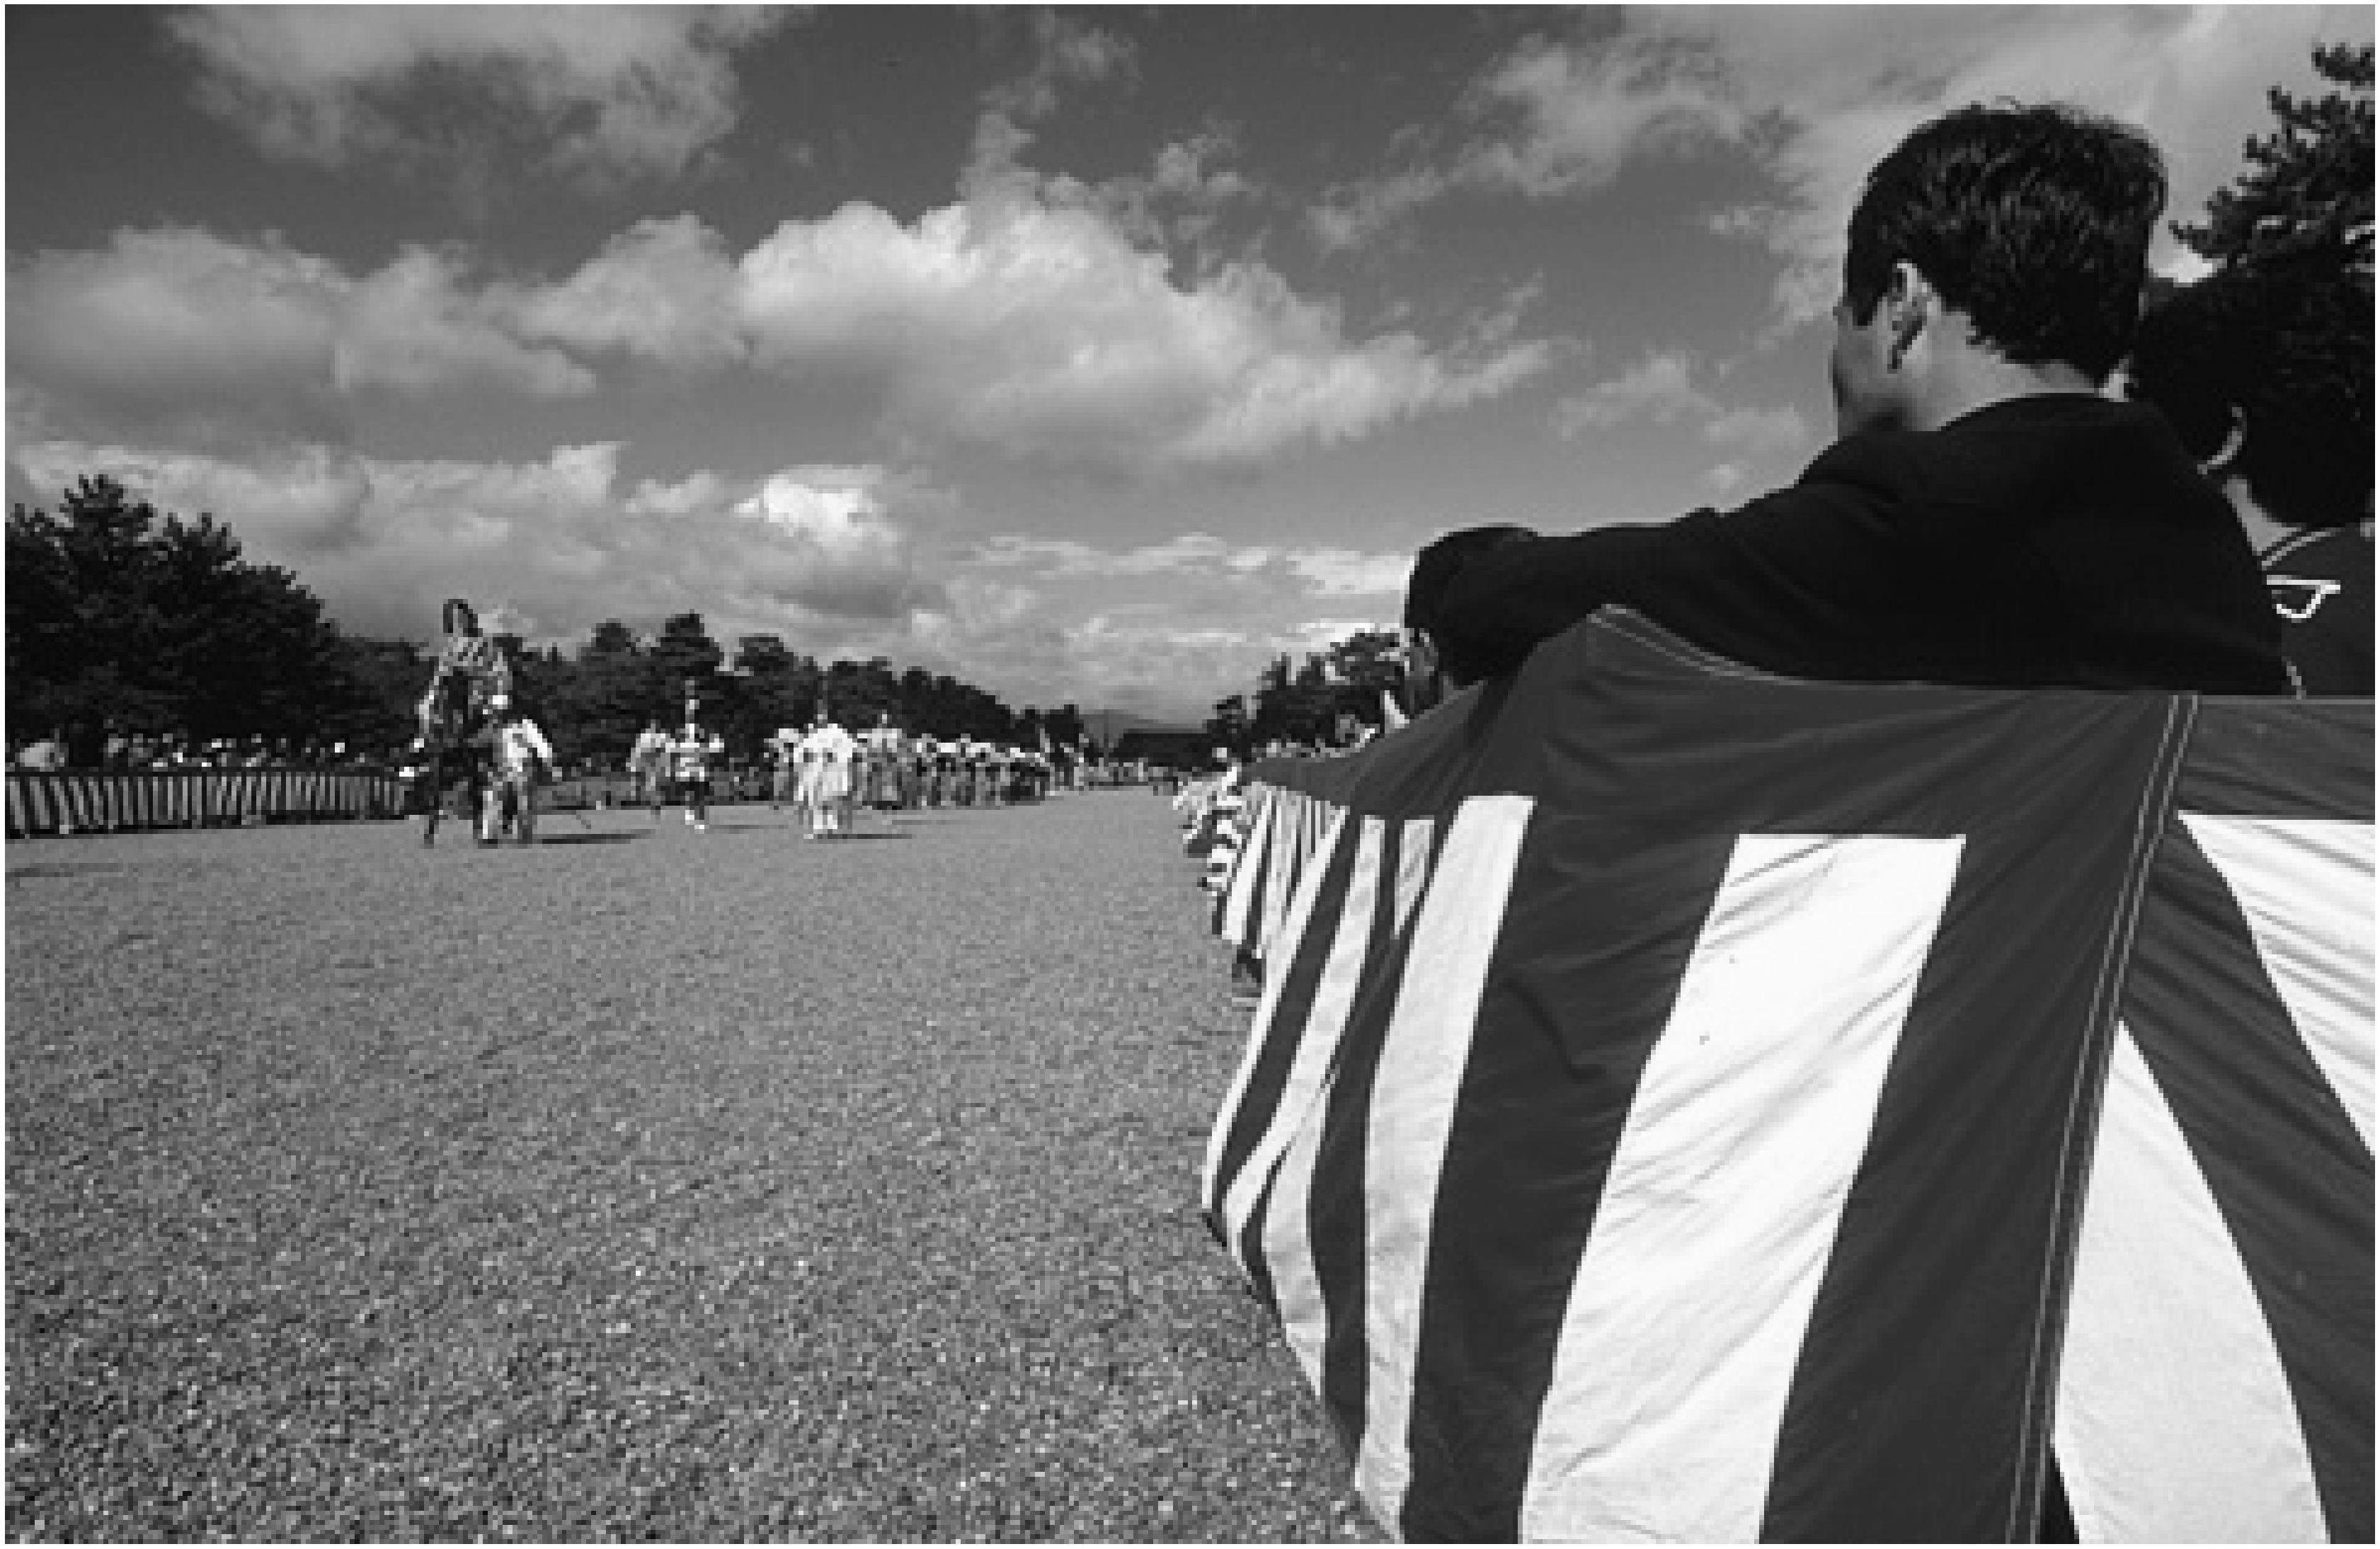

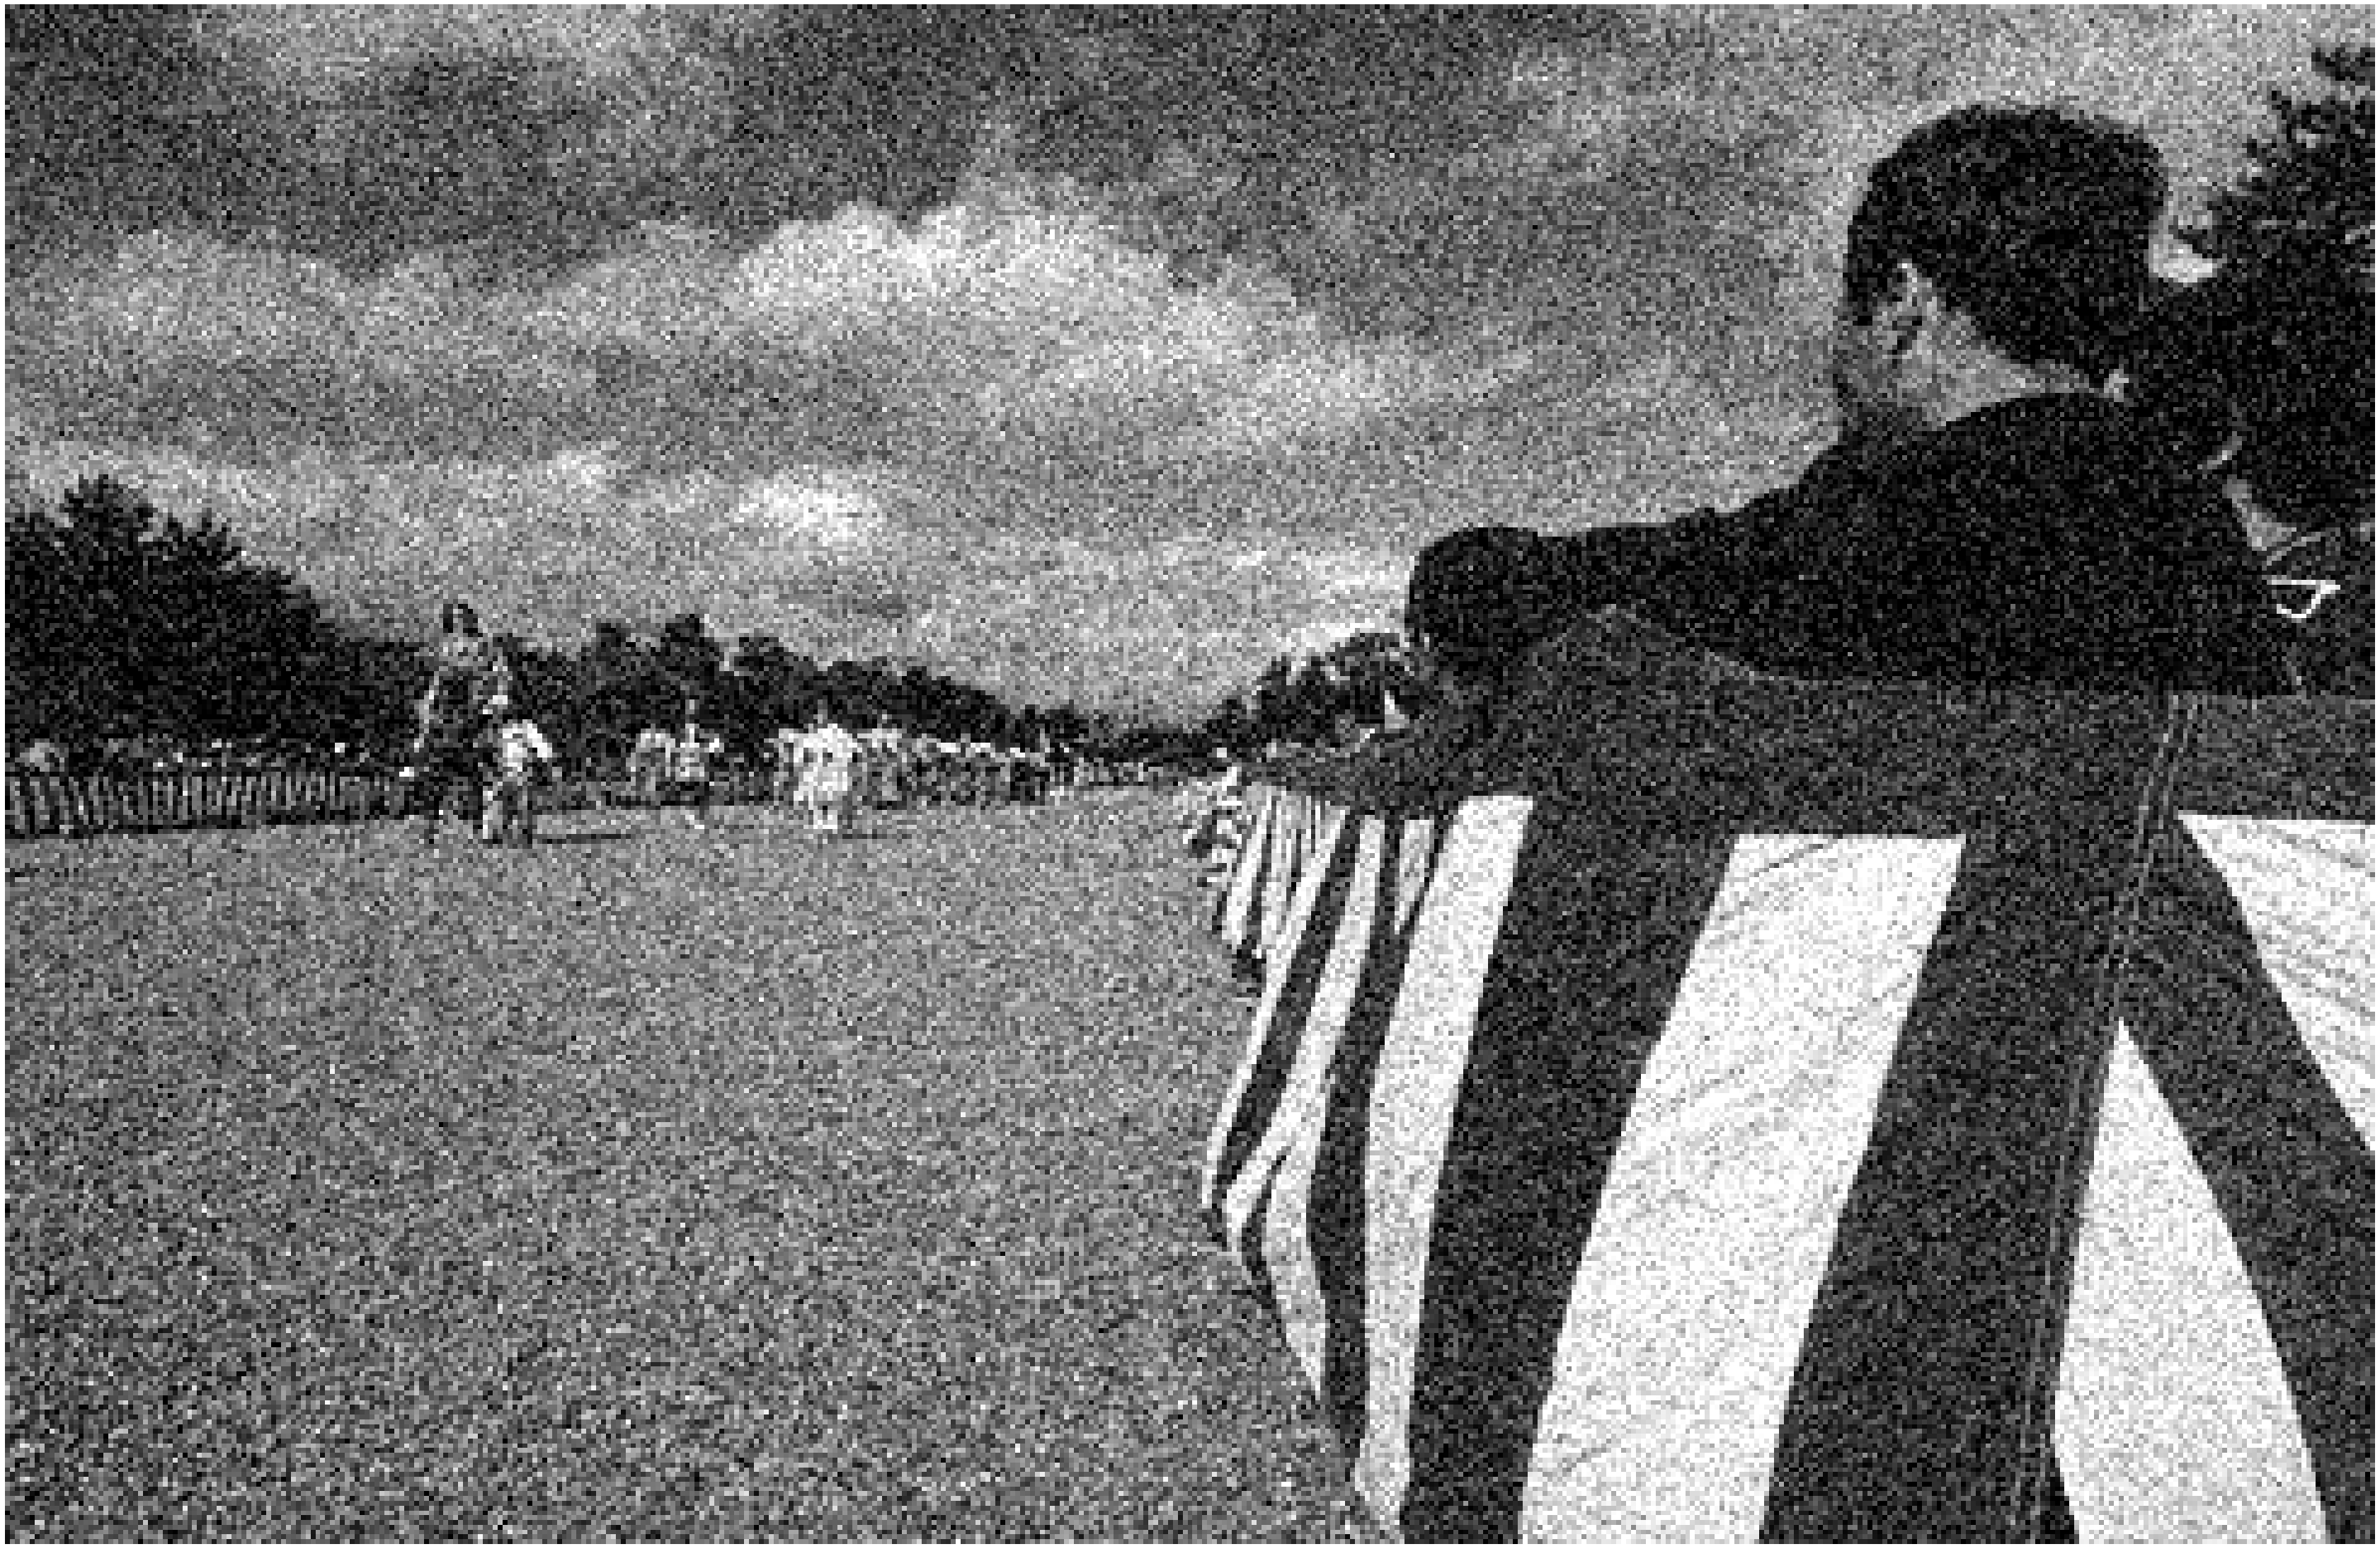

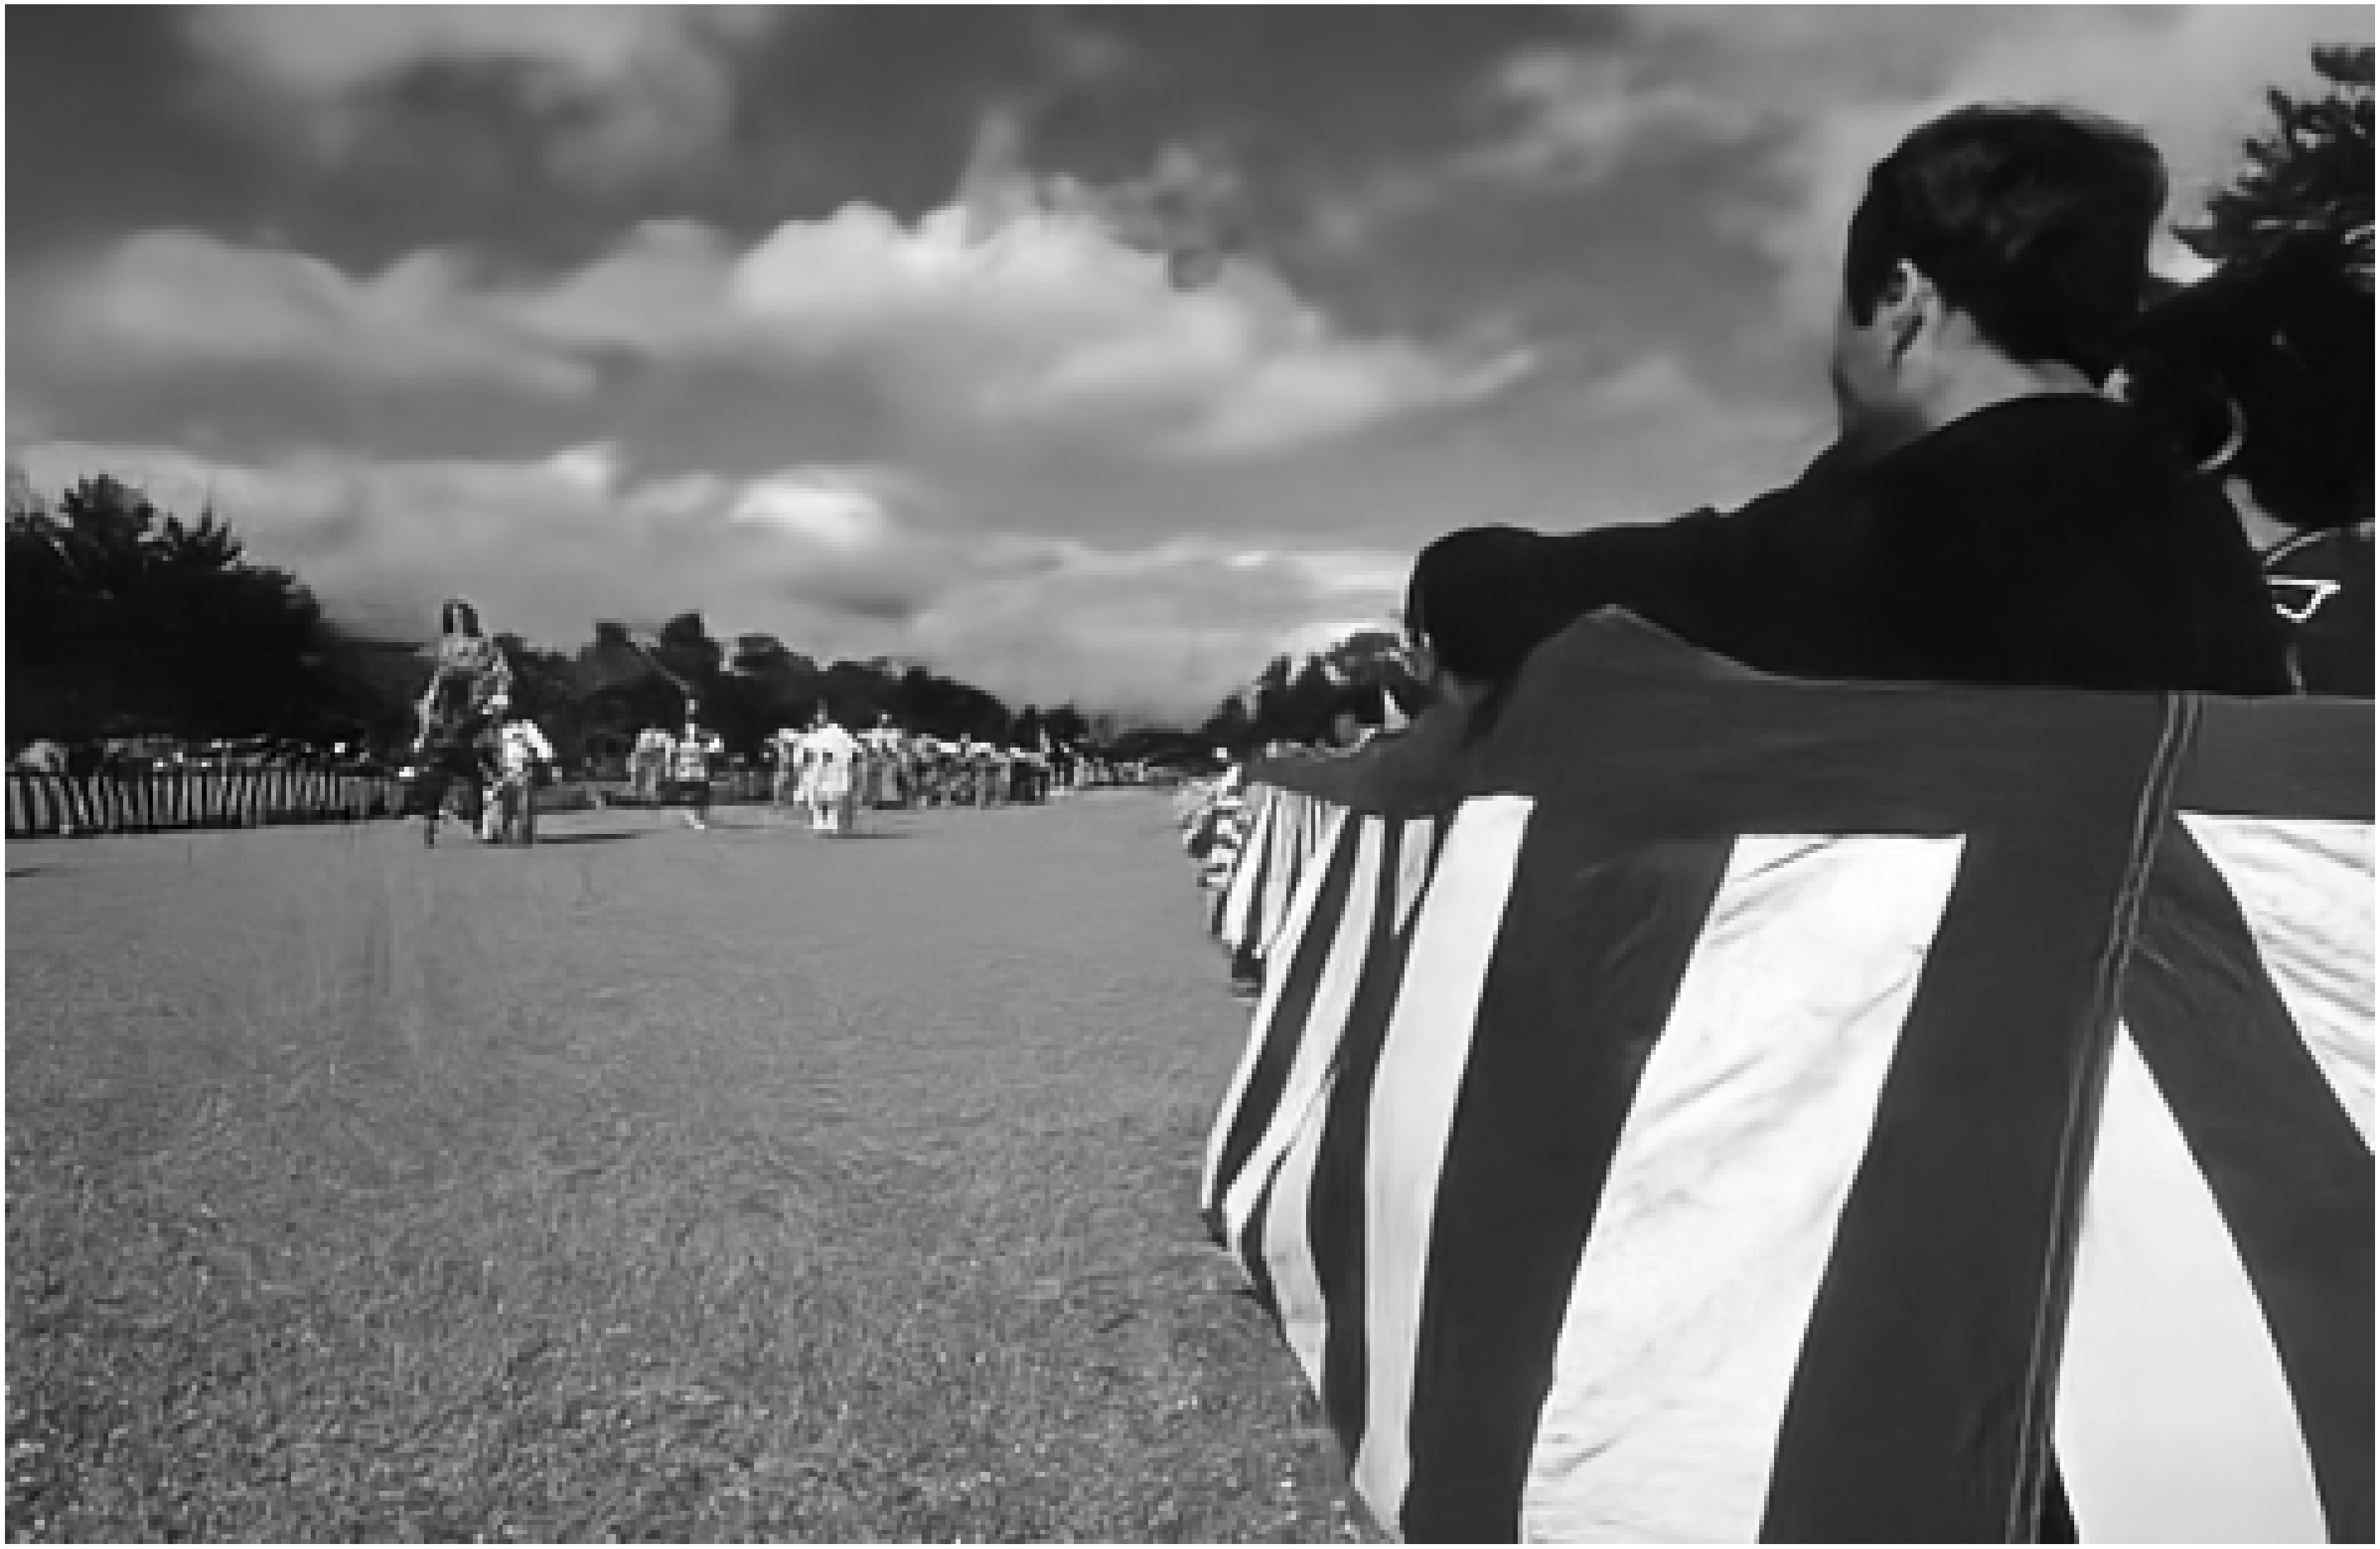

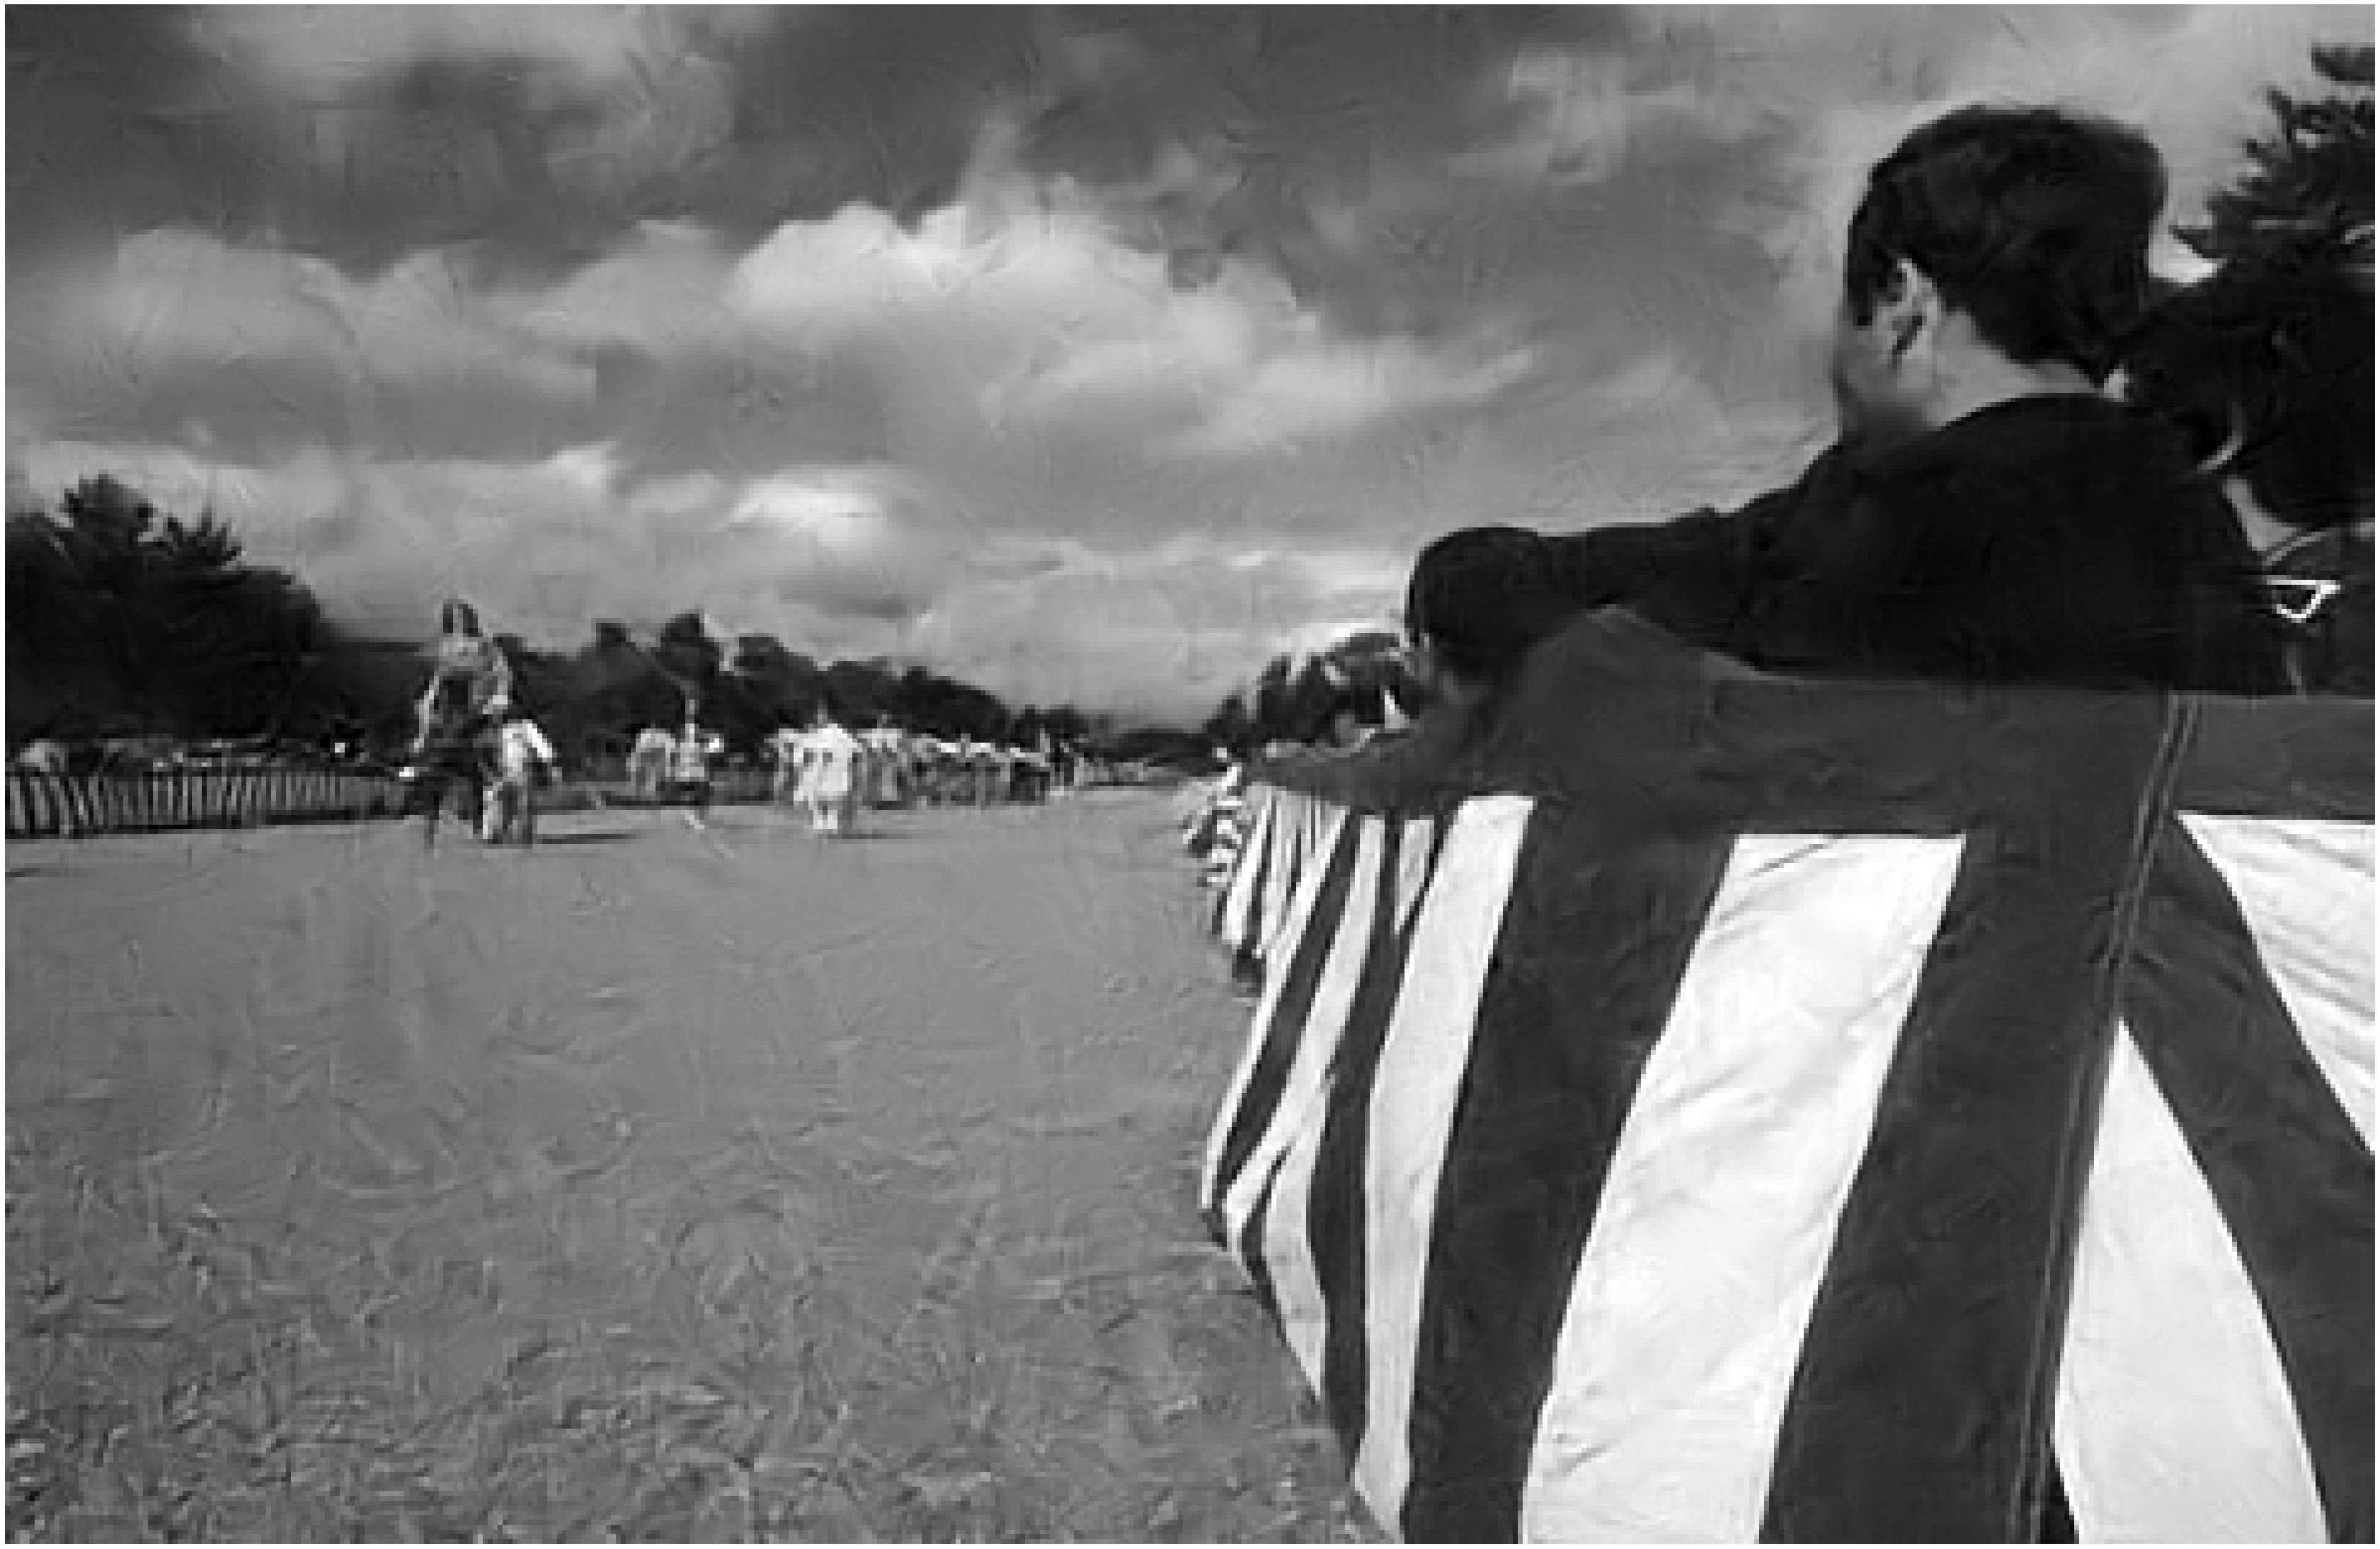

In [12]:
for name, im in images_to_plot.items():
    plt.figure()
    im_trimmed = trim_padding(orig_im_shape.numpy(), im.numpy())[0]
    plt.imshow(np.squeeze(im_trimmed), vmin=-0.5, vmax=0.5, aspect='auto')
    plt.axis('off')
    plt.savefig(f'denoising_{name}.png', bbox_inches='tight')

In [13]:
import bm3d

from learning_wavelets.wavelet_denoising import wavelet_denoising_pysap


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.4.1     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.2     installed
astropy        : >=3.0.0   - required | 3.2.3     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [14]:
im_noisy_numpy = np.squeeze(im_noisy.numpy())

In [15]:
im_denoised_bm3d = bm3d.bm3d(im_noisy_numpy + 0.5, sigma_psd=noise_std/255, stage_arg=bm3d.BM3DStages.ALL_STAGES) - 0.5
im_denoised_wavelets = wavelet_denoising_pysap([im_noisy_numpy], noise_std/255, '24', 5, False, 3)[0]

In [16]:
images_to_plot_numpy = {
    'bm3d': im_denoised_bm3d,
    'wavelets': im_denoised_wavelets,
}

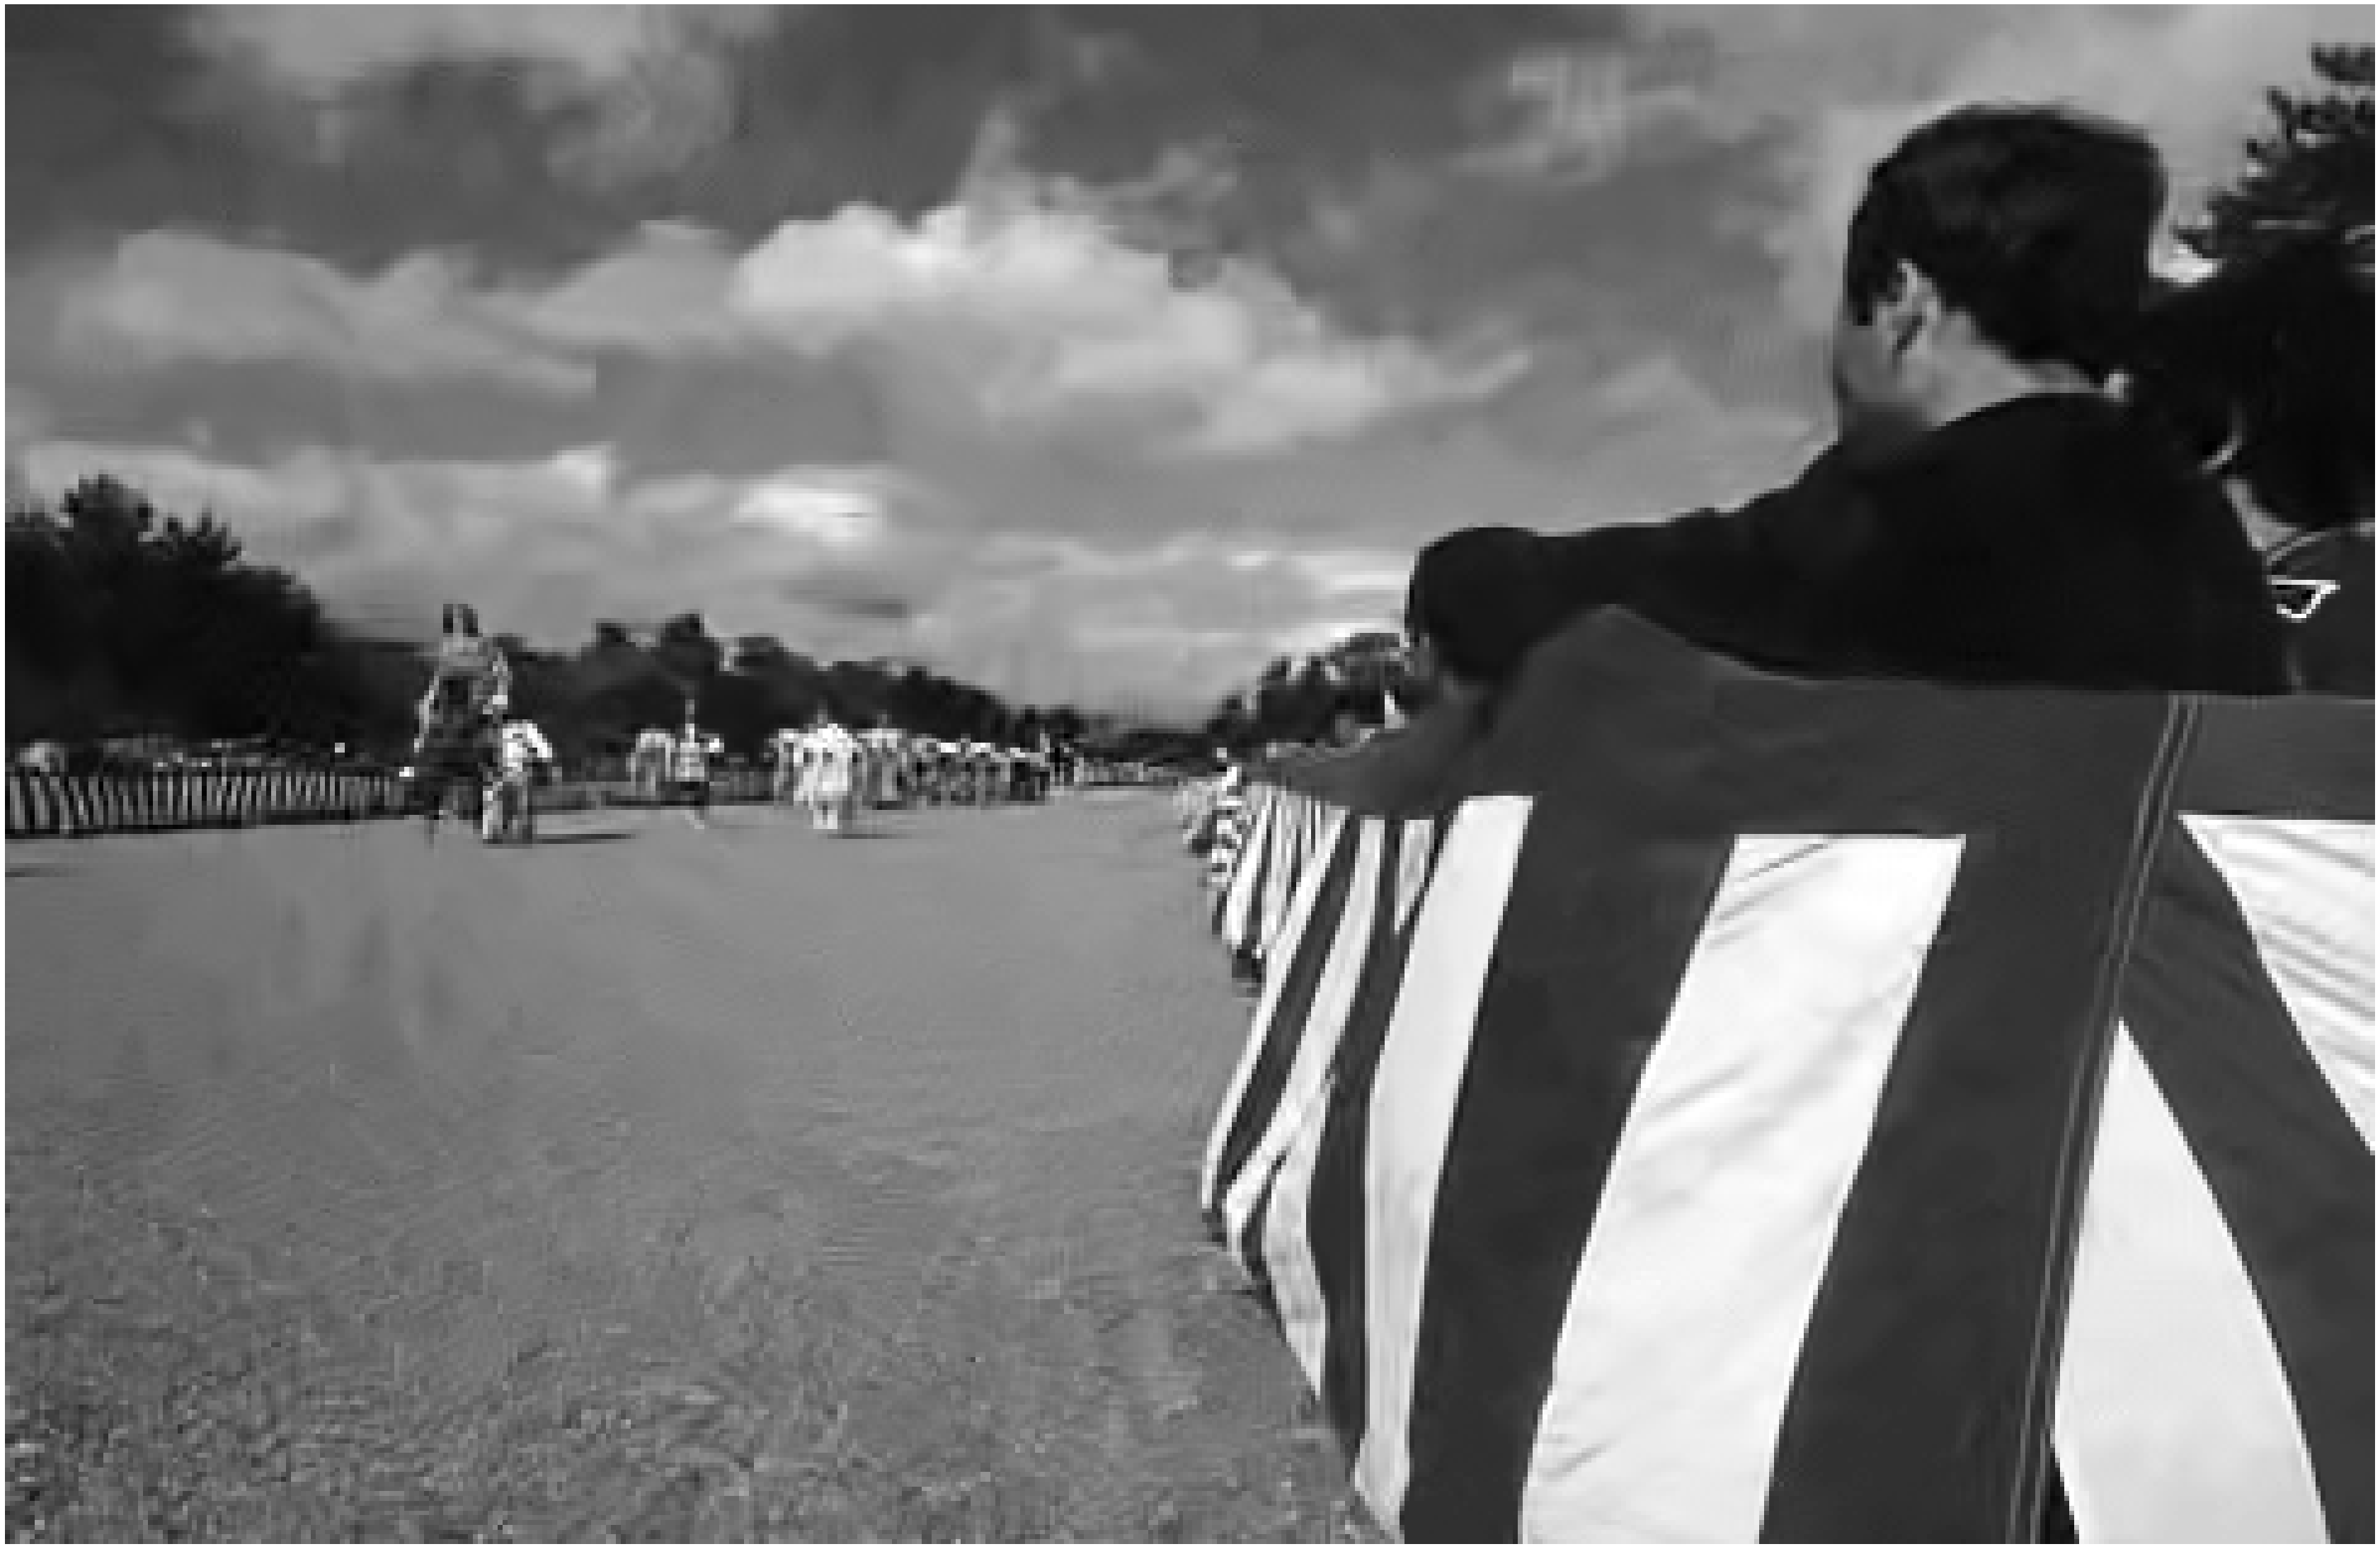

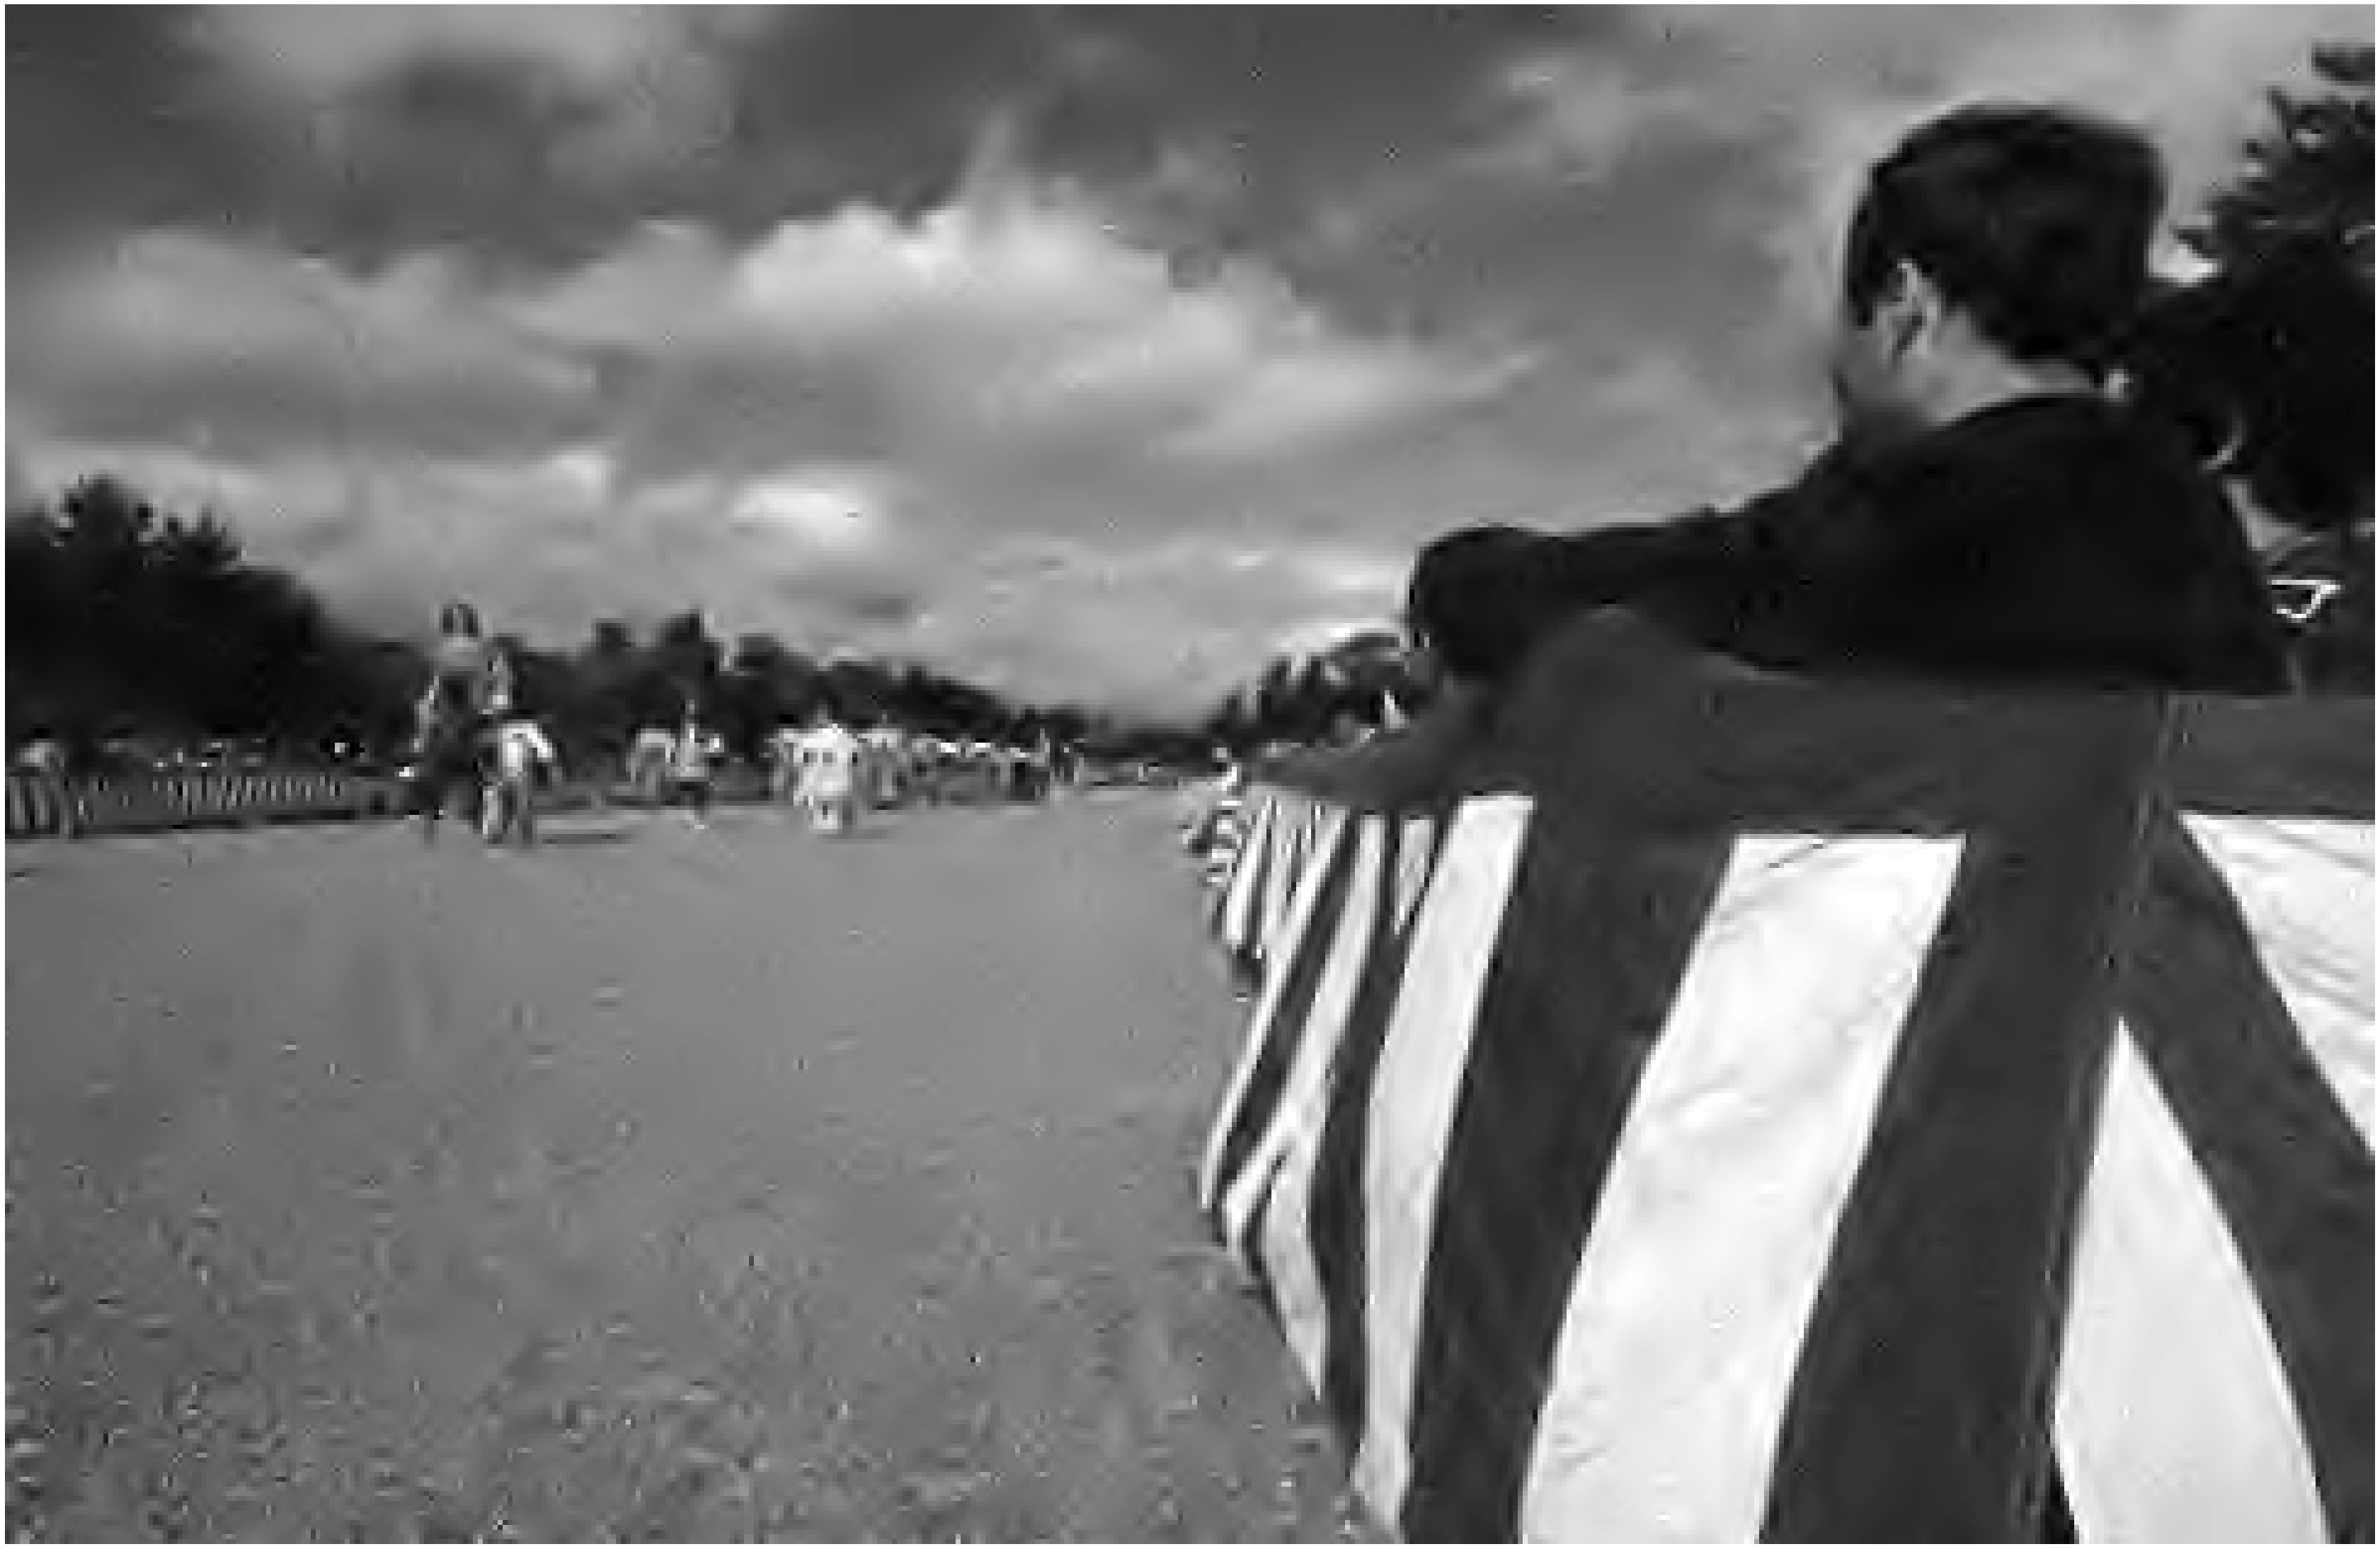

In [17]:
for name, im in images_to_plot_numpy.items():
    plt.figure()
    im_trimmed = trim_padding(orig_im_shape.numpy(), im[None, ..., None])[0]
    plt.imshow(np.squeeze(im_trimmed), vmin=-0.5, vmax=0.5, aspect='auto')
    plt.axis('off')
    plt.savefig(f'denoising_{name}.png', bbox_inches='tight')    